# All Dutch stations
This notebook shows an overview of all the metadata that is available for all Dutch stations that measure sea-surface height relative to MSL or to NAP. There are a few stations that measure relative to TAW, I think near the Maas. There are some technical issues with the webservices (you have to give locations in floating points) which can make the results a bit error prone. There are a number of incorrect locations in the dataset and some locations have their coordinates mixed up (lat, lon -> lon, lat). 

In [1]:
# default
import json
import urllib
import datetime
import os

# remote
import requests
import yarl

# data
import numpy as np
import pandas as pd
import xml.etree.ElementTree

# time
import dateutil.parser
# gis
import osgeo.osr
import geojson

import shapely #  after osr (does some weird things with geos)
import shapely.geometry
import netCDF4

import geopandas

# plotting
import matplotlib.pyplot as plt
import IPython.display
import tqdm

%matplotlib inline

In [2]:
# all the relevant url's 
# the documentation of these urls is here:
# https://www.rijkswaterstaat.nl/rws/opendata/DistributielaagWebservices-SUM-2v7.pdf
collect_catalogus = 'https://waterwebservices.rijkswaterstaat.nl/METADATASERVICES_DBO/OphalenCatalogus/'
collect_observations = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenWaarnemingen'
collect_latest_observations = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenLaatsteWaarnemingen'
collect_available_observations = 'https://waterwebservices.rijkswaterstaat.nl/ONLINEWAARNEMINGENSERVICES_DBO/OphalenAantalWaarnemingen'

# create all the geospatial reference objects that we use
# this dataset is mostly in utm31n/ETRS89
utm = osgeo.osr.SpatialReference()
utm.ImportFromEPSG(25831)
rd = osgeo.osr.SpatialReference()
rd.ImportFromEPSG(28992)
wgs84 = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
utm2wgs84 = osgeo.osr.CoordinateTransformation(utm, wgs84)
rd2wgs84 = osgeo.osr.CoordinateTransformation(rd, wgs84)


In [3]:
# start by reading all the locations, also include all other info, units, quantities and qualities?
request = {
    "CatalogusFilter": {
        "Eenheden": True,
        "Grootheden": True,
        "Hoedanigheden": True
    }
}
# this is an object that contains a lot of informatio
resp = requests.post(collect_catalogus, json=request)
result = resp.json()

# one of the relevant things is the list of locations
# index by id
df_locations = pd.DataFrame(result['LocatieLijst']).set_index('Locatie_MessageID')

# load normalized JSON object (since it contains nested JSON)
df_metadata = pd.io.json.json_normalize(
    result['AquoMetadataLijst']
).set_index('AquoMetadata_MessageID')

In [4]:
# show the list of water measurement quantities. 
# we only use the ones relative to NAP (coastal and inland) and MSL (offshore)
df_metadata[df_metadata['Grootheid.Code'] == 'WATHTE']


,Parameter_Wat_Omschrijving,Eenheid.Code,Eenheid.Omschrijving,Grootheid.Code,Grootheid.Omschrijving,Hoedanigheid.Code,Hoedanigheid.Omschrijving
AquoMetadata_MessageID,,,,,,,
30,Waterhoogte Oppervlaktewater t.o.v. Mean Sea L...,cm,centimeter,WATHTE,Waterhoogte,MSL,t.o.v. Mean Sea Level
31,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil


In [5]:
# combine station locations with what they measure
df_metadata_locations = pd.DataFrame(result['AquoMetadataLocatieLijst'])
location_info = df_metadata_locations.merge(
    df_metadata, 
    left_on='AquoMetaData_MessageID', 
    right_index=True
).merge(
    df_locations, 
    left_on='Locatie_MessageID', 
    right_index=True
)

# we have some stations that contain errornous info
# these are in colombia, someone did his PhD on some rivers in Columbia and he managed to put his data in the RWS production database.
in_colombia = location_info[location_info.X <= -1e7]
# these are just silly x,y y,x mixups
xy_yx_changed = location_info[location_info.X > 2000000].copy()

# Create an excel file with the errors, sent to RWS a few times
# in_colombia.to_excel('colombia.xlsx')
# xy_yx_changed.to_excel('xy_yx.xlsx')

# until they are fixed, we'll fix it ourselves

# one example of a correct station, one with xy reversed
# IJMDBTHVN = 605633.035699, 5.813598e+06
# EMPBNDN =   6681350., 886420.666850

# fix reversed XY
location_info.at[xy_yx_changed.index, 'X'] = xy_yx_changed['Y']
location_info.at[xy_yx_changed.index, 'Y'] = xy_yx_changed['X']

# now we only have colombia left, toss em out
location_info = location_info.drop(in_colombia.index)


Text(0.5, 1.0, 'fixed locations')

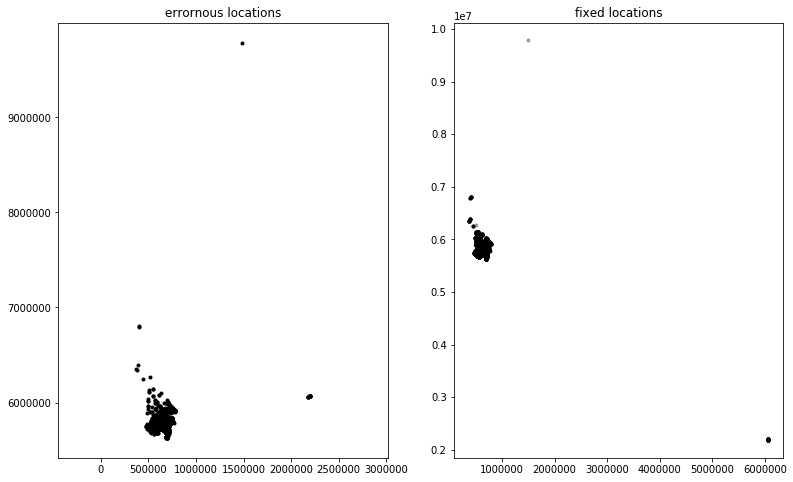

In [6]:
# now we should only have correct measurements in NL
fig, axes = plt.subplots(ncols=2, figsize=(13, 8))
axes[0].plot(df_locations.X, df_locations.Y, 'k.')
axes[0].axis('equal')
axes[0].set_title('errornous locations')
axes[1].plot(location_info.X, location_info.Y, 'k.', alpha=0.3)
axes[1].axis('equal')
axes[1].set_title('fixed locations')

In [8]:
# show info from 1 station
location_info.set_index('Code').loc['IJMDBTHVN']

,AquoMetaData_MessageID,Locatie_MessageID,Parameter_Wat_Omschrijving,Eenheid.Code,Eenheid.Omschrijving,Grootheid.Code,Grootheid.Omschrijving,Hoedanigheid.Code,Hoedanigheid.Omschrijving,Coordinatenstelsel,X,Y,Naam
Code,,,,,,,,,,,,,
IJMDBTHVN,29,93757,Waterhoogte berekend Oppervlaktewater t.o.v. N...,cm,centimeter,WATHTBRKD,Waterhoogte berekend,NAP,t.o.v. Normaal Amsterdams Peil,25831,605633.035699,5.813598e+06,IJmuiden buitenhaven
IJMDBTHVN,31,93757,Waterhoogte Oppervlaktewater t.o.v. Normaal Am...,cm,centimeter,WATHTE,Waterhoogte,NAP,t.o.v. Normaal Amsterdams Peil,25831,605633.035699,5.813598e+06,IJmuiden buitenhaven
IJMDBTHVN,95,93757,Temperatuur Oppervlaktewater oC,oC,graad Celsius,T,Temperatuur,NVT,Niet van toepassing,25831,605633.035699,5.813598e+06,IJmuiden buitenhaven


In [12]:
# convert from utm to wgs84

lonlatz = np.array(utm2wgs84.TransformPoints(location_info[['X', 'Y']].values))
location_info['lat'] = lonlatz[:, 1]
location_info['lon'] = lonlatz[:, 0]

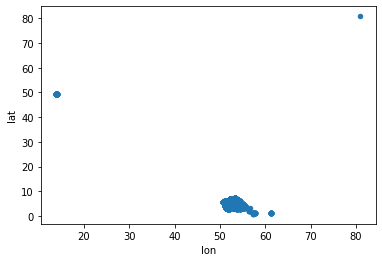

In [13]:
# show locations
location_info.plot('lon', 'lat', kind='scatter')

In [14]:
# There are 54 stations that moved or changed from measurement type. Euro platform switched to NAP at some point.
multiple_locations_per_station = location_info[location_info['Grootheid.Code'] == 'WATHTE'].groupby('Code').count()['AquoMetaData_MessageID'] > 1
multiple_locations_per_station = multiple_locations_per_station[multiple_locations_per_station]
multiple_locations_per_station.index, len(multiple_locations_per_station.index)

(Index(['A12', 'AADP', 'BATH', 'D15', 'ECHT', 'EPL', 'EURPFM', 'F16', 'J6',
        'LICHTELGRE', 'LOBH', 'MOOK', 'NEER', 'NES', 'OLST', 'Q1', 'WELL'],
       dtype='object', name='Code'), 17)

In [15]:
# show data for 1 station, Den Helder in this case to check
station = location_info[location_info['Grootheid.Code'] == 'WATHTE'].set_index('Code').loc['DENHDR']
station


AquoMetaData_MessageID                                                       31
Locatie_MessageID                                                         93686
Parameter_Wat_Omschrijving    Waterhoogte Oppervlaktewater t.o.v. Normaal Am...
Eenheid.Code                                                                 cm
Eenheid.Omschrijving                                                 centimeter
Grootheid.Code                                                           WATHTE
Grootheid.Omschrijving                                              Waterhoogte
Hoedanigheid.Code                                                           NAP
Hoedanigheid.Omschrijving                        t.o.v. Normaal Amsterdams Peil
Coordinatenstelsel                                                        25831
X                                                                        617198
Y                                                                   5.86973e+06
Naam                                    

In [16]:
# unfortunately this takes too long, so we can't use this API to get timespans
req = {
    "AquoMetadataLijst": [
        {
            "Grootheid": {
                "Code": station['Grootheid.Code']
            }
        }
    ],
    "Groeperingsperiode" : "Jaar",
    "LocatieLijst": [
        {
            "X": station.X, 
            "Y": station.Y,
            "Code": station.name
        }
    ],
    "Periode": {
        "Begindatumtijd" : "1700-01-01T00:00:00.000+01:00",
        "Einddatumtijd": "2013-01-01T00:00:00.000+01:00"
    }
}
# resp = requests.post(collect_available_observations, json=req)
# data = resp.json()


In [17]:
# so we'll use our own copies of the datasets in OpenEarth
catalog_onshore = 'http://opendap.deltares.nl/thredds/catalog/opendap/rijkswaterstaat/waterbase/27_Waterhoogte_in_cm_t.o.v._normaal_amsterdams_peil_in_oppervlaktewater/nc/catalog.xml'
catalog_offshore = 'http://opendap.deltares.nl/thredds/catalog/opendap/rijkswaterstaat/waterbase/26_Waterhoogte_in_cm_t.o.v._mean_sea_level_in_oppervlaktewater/nc/catalog.xml'


In [18]:
def read_catalog(url):
    '''return all netcdf files in a catalog.xml file'''

    fp = urllib.request.urlopen(url)
    root = xml.etree.ElementTree.parse(fp)
    fp.close()
    
    
    for item in root.iter():
        if item.tag.endswith('dataset'):
            if item.attrib['name'].endswith('.nc'):
                yield str(
                    yarl.URL(url).with_name(item.attrib['name'])
                ).replace('/catalog/', '/dodsC/')


In [19]:
# create a list of all available url's
urls_onshore = list(read_catalog(catalog_onshore))
urls_offshore = list(read_catalog(catalog_offshore))
urls = urls_onshore + urls_offshore

In [ ]:
rows = []
for url in tqdm.tqdm_notebook(urls):
    row = {}
    with netCDF4.Dataset(url) as ds:
        for attr in ds.ncattrs():
            row[attr] = getattr(ds, attr)
    row['url'] = url
    rows.append(row)

In [ ]:
# collect all info, convert points to geospatial objects
df = pd.DataFrame(rows)
df['lat'] = df['geospatial_lat_min']
df['lon'] = df['geospatial_lon_min']
df['point'] = df.apply(lambda row: shapely.geometry.Point(row.lon, row.lat), axis=1)
df['is_onshore'] = df['url'].apply(lambda x: x in urls_onshore)
df['is_offshore'] = df['url'].apply(lambda x: x in urls_offshore)

In [ ]:
# separate coast and offshore and other
coast_json = {"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[3.2299804687499996,51.52925135518991],[3.427734375,51.172455303299],[4.3011474609375,51.26535213392538],[4.29840087890625,51.42832700421254],[3.6090087890625004,51.515579783755925],[3.7628173828124996,51.67255514839674],[3.93310546875,51.80691653515817],[4.04296875,51.80691653515817],[4.119873046875,51.87309959004367],[4.42474365234375,51.82559340146247],[4.29290771484375,52.05924589011585],[4.64447021484375,52.399067302933304],[4.87518310546875,52.826001860971836],[5.438232421875,53.108865487028616],[5.847473144531249,53.32759237756109],[6.30615234375,53.337433437129675],[6.712646484375,53.28492154619624],[7.086181640625,53.1928702436326],[7.283935546874999,53.199451902831555],[7.218017578125001,53.44880683542759],[6.8994140625,53.75520681580145],[5.44921875,65.25670649344259],[-9.4921875,63.39152174400882],[0.85693359375,52.01869808104436],[3.2299804687499996,51.52925135518991]]]}}]}
coast = shapely.geometry.asShape(geojson.GeoJSON(coast_json)['features'][0]['geometry'])
df['is_coast'] = df['point'].apply(lambda point: coast.contains(point))


In [ ]:
fig, ax = plt.subplots()
ax.scatter(df['lon'], df['lat'], c=df['is_coast'])
ax.axis('equal')

In [ ]:
# show number of stations
df.groupby('is_coast')['is_coast'].count()

In [ ]:
# split coastal stations into offshore and onshore
df[df['is_coast'] == True].groupby('is_onshore').count()['is_coast']


In [ ]:
# convert to spatial data frame
gdf = geopandas.GeoDataFrame(df, geometry='point')

In [ ]:
# parse dates, what is that P doing there.
df['time_start'] = df['time_coverage_start'].apply(lambda x: dateutil.parser.parse(x.replace('P', 'T')))
df['time_end'] = df['time_coverage_end'].apply(lambda x: dateutil.parser.parse(x.replace('P', 'T')))
df['is_active'] = df['time_end'].apply(lambda x: x > datetime.datetime(2017, 1, 1))

In [ ]:
fig, ax = plt.subplots(figsize=(13, 20))
selected = df[df['is_coast']].sort_values(['time_start', 'time_end']).reset_index()

active_colors = {
    True: 'green',
    False: 'red'
}
offshore_linestyle = {
    True: 'dotted',
    False: 'solid'
    
}
for i, row in selected.iterrows():
    ax.hlines(
        i, 
        row['time_start'], 
        row['time_end'], 
        colors=active_colors[row['is_active']], 
        linestyles=offshore_linestyle[row['is_offshore']]
    )
    ax.annotate(row['location'], (row['time_start'], i), horizontalalignment='right')
ax.yaxis.set_visible(False)
ax.grid(True)
ax.set_xlabel('Date')
fig.savefig('waterbase.pdf')